Take Home Assignment 3

3.0 Install any dependencies if needed


In [1]:
!pip install supervision
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.7/914.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [2]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import time
import supervision as sv

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


3.1.1 Draw the segmentation mask of the largest car: Use ultralytics library only

In [3]:
img = cv2.imread("demo5_images/cars1.jpg")


0: 416x640 14 cars, 664.7ms
Speed: 4.3ms preprocess, 664.7ms inference, 45.7ms postprocess per image at shape (1, 3, 416, 640)


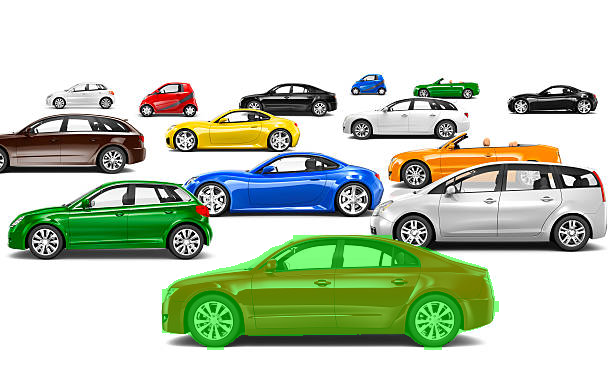

True

In [9]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# Load YOLOv8 model (Ensure you have the segmentation model)
model = YOLO("yolov8s-seg.pt")

# Load image
image_path = "/content/demo5_images/cars1.jpg"  # Replace with your image path
image = cv2.imread(image_path)

# Check if image is loaded correctly
if image is None:
    raise FileNotFoundError(f"Error: Image not found at {image_path}. Check the file path.")

# Run inference
results = model(image)

# Extract masks, class IDs, and bounding boxes
masks = results[0].masks.xy  # Segmentation masks
boxes = results[0].boxes.xyxy  # Bounding boxes
class_ids = results[0].boxes.cls  # Class IDs

# Find the largest car
max_area = 0
largest_mask = None
for mask, box, cls in zip(masks, boxes, class_ids):
    if int(cls) == 2:  # Class ID 2 corresponds to 'car' in COCO dataset
        x1, y1, x2, y2 = box
        area = (x2 - x1) * (y2 - y1)
        if area > max_area:
            max_area = area
            largest_mask = np.array(mask, np.int32)

# Draw the largest car mask
if largest_mask is not None:
    overlay = image.copy()
    cv2.fillPoly(overlay, [largest_mask], (0, 255, 0))  # Green mask
    image = cv2.addWeighted(overlay, 0.5, image, 0.5, 0)

# Show result in Colab
cv2_imshow(image)

# Save output
cv2.imwrite("/content/demo5_images/cars1.jpg", image)


3.1.2 Draw the segmentation mask of the largest car : Use ultralytics + supervision libraries

100%|██████████| 6.74M/6.74M [00:00<00:00, 75.5MB/s]



0: 416x640 14 cars, 237.9ms
Speed: 4.4ms preprocess, 237.9ms inference, 60.2ms postprocess per image at shape (1, 3, 416, 640)


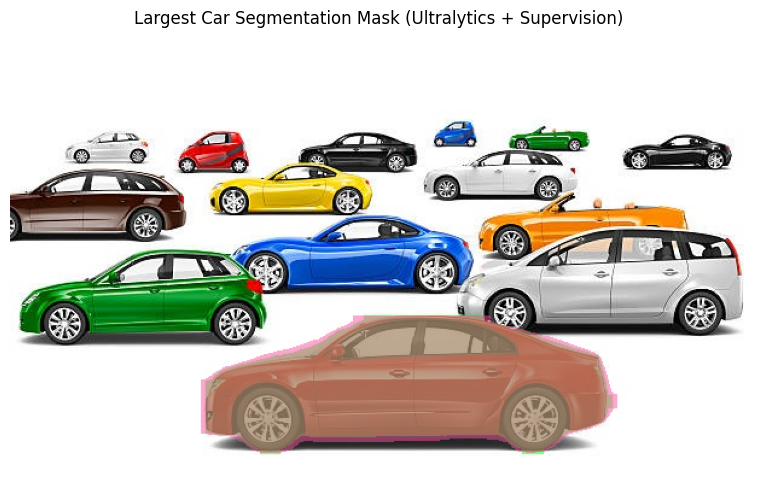

In [16]:
# Load YOLOv8 segmentation model
model = YOLO("yolov8n-seg.pt")  # Ensure you have YOLOv8 segmentation model

# Read the image
img = cv2.imread("demo5_images/cars1.jpg")

# Check if the image is loaded properly
if img is None:
    raise FileNotFoundError("Image file not found. Check the file path!")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying

# Run segmentation model
results = model(img_rgb)

# Create Supervision annotator for masks
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Extract the largest car mask and corresponding bounding box
largest_detection = None

for r in results:
    detections = sv.Detections.from_ultralytics(r)

    # Filter for 'car' class (class_id == 2)
    car_detections = [(mask, bbox) for mask, bbox, class_id in zip(detections.mask, detections.xyxy, detections.class_id) if class_id == 2]

    # Find the largest car mask
    largest_detection = max(car_detections, key=lambda x: np.count_nonzero(x[0]), default=None)

# Draw the largest car mask
if largest_detection:
    largest_mask, largest_bbox = largest_detection
    detections = sv.Detections(xyxy=np.array([largest_bbox]), mask=np.array([largest_mask]))
    mask_img = mask_annotator.annotate(scene=img_rgb, detections=detections)

    # Display result
    plt.figure(figsize=(10, 6))
    plt.imshow(mask_img)
    plt.axis("off")
    plt.title("Largest Car Segmentation Mask (Ultralytics + Supervision)")
    plt.show()
else:
    print("No car detected in the image.")


3.2 Estimate distance to centroid of chair

Device set to use cpu



0: 384x640 1 chair, 276.7ms
Speed: 4.3ms preprocess, 276.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Chair centroid: (352, 181), Estimated distance: 146


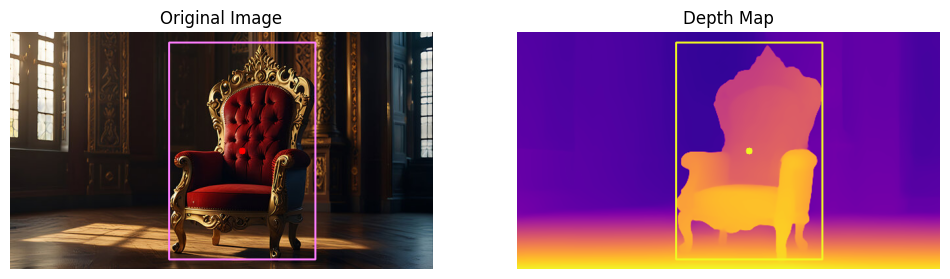

In [21]:
import cv2
import torch
import numpy as np
import supervision as sv
from ultralytics import YOLO
from transformers import pipeline
from PIL import Image
import matplotlib.pyplot as plt

# Load YOLO model for chair detection
detection_model = YOLO("yolov8n.pt")  # Use a suitable YOLO model

# Load Depth Anything V2 Small with GPU acceleration and FP16 precision if available
device = "cuda" if torch.cuda.is_available() else "cpu"
depth_estimator = pipeline(
    task="depth-estimation",
    model="depth-anything/Depth-Anything-V2-Small-hf",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

def detect_chair(image):
    # Run chair detection and return bounding boxes and centroids
    results = detection_model(image)[0]
    return [
        (int(box.xyxy[0][0]), int(box.xyxy[0][1]), int(box.xyxy[0][2]), int(box.xyxy[0][3]),
         ((int(box.xyxy[0][0]) + int(box.xyxy[0][2])) // 2, (int(box.xyxy[0][1]) + int(box.xyxy[0][3])) // 2))
        for box in results.boxes if results.names[int(box.cls.item())] == "chair"
    ]

def estimate_depth(image_path):
    # Estimate depth map using Depth Anything pipeline
    image = Image.open(image_path)
    return np.array(depth_estimator(image)["depth"])

def annotate_chairs(image, chairs, depth_map):
    # Annotate chairs on the image and depth map
    for x1, y1, x2, y2, centroid in chairs:
        depth = depth_map[centroid[1], centroid[0]]
        print(f"Chair centroid: {centroid}, Estimated distance: {depth}")
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 125, 812), 2)
        cv2.circle(image, centroid, 5, (255, 0, 0), -1)
        cv2.rectangle(depth_map, (x1, y1), (x2, y2), (255, 125, 128), 2)
        cv2.circle(depth_map, centroid, 5, (255, 0, 0), -1)

def main(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib
    chairs = detect_chair(image_rgb)
    depth_map = estimate_depth(image_path)
    depth_map_rgb = np.stack([depth_map] * 3, axis=-1)  # Convert to 3-channel for visualization

    if chairs:
        annotate_chairs(image_rgb, chairs, depth_map)
    else:
        print("No chair detected.")

    # Display the results
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(depth_map, cmap='plasma')
    axes[1].set_title("Depth Map")
    axes[1].axis("off")

    plt.show()

# Example usage
main("demo5_images/kingChair.jpg")


3.3.1  Draw bounding boxes around the "cars" using supervision.

In [22]:
# Downloads the video file from the google drive link, you'll have to "pip install gdown" first
import gdown

file_id = "1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4"
direct_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(direct_url, "vehicles_video.mp4", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4
To: /content/vehicles_video.mp4
100%|██████████| 35.3M/35.3M [00:00<00:00, 69.4MB/s]


'vehicles_video.mp4'

In [24]:
model = YOLO("yolo11n.pt")


def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Complete this function

    sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="result_tracking.mp4",
    callback=callback
)

100%|██████████| 5.35M/5.35M [00:00<00:00, 44.9MB/s]


3.3.1 Track the cars. Add the tracker id to the bounding boxes around the cars. Use supervision

In [26]:
import numpy as np
import supervision as sv
from ultralytics import YOLO

# ... (rest of the code remains the same)

def process_frame(frame: np.ndarray, index: int = None) -> np.ndarray: # Add index parameter
    """
    Processes a single frame, detecting vehicles and updating tracking.
    """
    results = model(frame)[0]

    # Filter detections to include only vehicles
    vehicle_detections = filter_vehicle_detections(results)

    # Track the filtered vehicle detections
    tracked_detections = tracker.update_with_detections(vehicle_detections)

    # Generate tracking labels
    labels = generate_labels(tracked_detections, results)

    # Annotate the frame with bounding boxes and labels
    annotated_frame = box_annotator.annotate(frame.copy(), detections=tracked_detections)
    return label_annotator.annotate(annotated_frame, detections=tracked_detections, labels=labels)

# Process video with the defined callback function
sv.process_video(
    source_path="vehicles_video.mp4",  # Provide the correct path
    target_path="result_track_vehicles.mp4",
    callback=process_frame
)


0: 384x640 3 cars, 1 truck, 290.0ms
Speed: 9.4ms preprocess, 290.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 233.0ms
Speed: 6.0ms preprocess, 233.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 301.4ms
Speed: 6.4ms preprocess, 301.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 274.6ms
Speed: 8.9ms preprocess, 274.6ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 277.2ms
Speed: 9.1ms preprocess, 277.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 253.5ms
Speed: 5.4ms preprocess, 253.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 304.2ms
Speed: 5.6ms preprocess, 304.2ms inference, 8.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 275.8ms
Speed: 6.6ms prepr

3.3.2 Draw the track traces for the tracked cars. Use supervision

In [28]:
import numpy as np
import supervision as sv
from ultralytics import YOLO
import cv2

# Load the YOLO model
model = YOLO("yolo11n.pt")
tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Vehicle class IDs based on COCO dataset (adjust as needed)
vehicle_class_ids = [2, 7]

# Dictionary to store the path of each vehicle (tracker_id -> list of positions)
vehicle_paths = {}

def filter_vehicle_detections(results):
    """
    Filters the detections to only include vehicles based on class IDs.
    """
    detections = sv.Detections.from_ultralytics(results)
    return detections[np.isin(detections.class_id, vehicle_class_ids)]

def update_vehicle_paths(tracked_detections, frame, results):  # Add results as an argument
    """
    Updates the path of each tracked vehicle and draws the path on the frame.
    """
    labels = []
    for i, (tracker_id, class_id) in enumerate(zip(tracked_detections.tracker_id, tracked_detections.class_id)):
        label = f"#{tracker_id} {results.names[class_id]}"  # Now results is correct
        labels.append(label)

        # Calculate the center of the bounding box
        x1, y1, x2, y2 = tracked_detections.xyxy[i]
        x_center = int((x1 + x2) / 2)
        y_center = int((y1 + y2) / 2)

        # Initialize path for a new vehicle
        if tracker_id not in vehicle_paths:
            vehicle_paths[tracker_id] = []

        # Add the center to the vehicle's path
        vehicle_paths[tracker_id].append((x_center, y_center))

        # Draw the path (connecting previous positions with a line)
        path = vehicle_paths[tracker_id]
        if len(path) > 1:
            for i in range(1, len(path)):
                cv2.line(frame, path[i - 1], path[i], (0, 255, 0), 2)  # Green line

    return labels

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Run YOLO model on the frame
    results = model(frame)[0]

    # Filter the detections to include only vehicles
    vehicle_detections = filter_vehicle_detections(results)

    # Track the filtered detections
    tracked_detections = tracker.update_with_detections(vehicle_detections)

    # Update the vehicle paths and generate labels (pass results to the function)
    labels = update_vehicle_paths(tracked_detections, frame, results)

    # Annotate the frame with bounding boxes and labels
    annotated_frame = box_annotator.annotate(frame.copy(), detections=tracked_detections)
    return label_annotator.annotate(annotated_frame, detections=tracked_detections, labels=labels)

# Process video with the callback function
sv.process_video(
    source_path="vehicles_video.mp4",  # Ensure the correct path here
    target_path="result_with_traces.mp4",
    callback=callback
)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



0: 384x640 3 cars, 1 truck, 256.9ms
Speed: 5.3ms preprocess, 256.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 224.7ms
Speed: 6.3ms preprocess, 224.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 264.0ms
Speed: 13.1ms preprocess, 264.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 272.6ms
Speed: 6.4ms preprocess, 272.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 277.2ms
Speed: 6.1ms preprocess, 277.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 281.6ms
Speed: 6.3ms preprocess, 281.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 302.3ms
Speed: 7.8ms preprocess, 302.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 285.6ms
Speed: 6.2ms prep

Questions:

Explain what "def callback(frame: np.ndarray, _: int) -> np.ndarray:" does.

Answers: Complete this section

The function definition `def callback(frame: np.ndarray, _: int) -> np.ndarray:` is used in the context of processing video frames in a real-time or batch video processing system.

1. **`def callback`**:
   - `def` is a keyword in Python used to define a function.
   - `callback` is the name of the function. In this case, it suggests that the function is intended to handle or "call back" a specific operation each time a video frame is processed.

2. **`(frame: np.ndarray, _: int)`**:
   - `(frame: np.ndarray, _: int)` are the parameters that the function accepts.
     - `frame`: This parameter represents a single frame of the video, which is an image or array of pixel values. The type hint `np.ndarray` indicates that this parameter is expected to be a NumPy array, commonly used to represent images in Python.
     - `_: int`: The underscore (`_`) is a common convention in Python when a parameter is not going to be used in the function body. In this case, it represents an integer value (which could be a frame number or timestamp), but it is intentionally not used in the function, hence the underscore is used to indicate that it is a placeholder.

3. **`-> np.ndarray:`**:
   - This is the return type hint for the function. It indicates that the function will return an object of type `np.ndarray`, which is a NumPy array. In this context, the returned value is the processed video frame after the function has finished annotating or modifying it.

### Overall Function Purpose:
The `callback` function is designed to process each frame of the video by running object detection (e.g., using YOLO) and tracking (e.g., using ByteTrack) on the given `frame`. It then annotates the frame with relevant information (such as bounding boxes and tracking labels) and returns the modified frame (`np.ndarray`) to be saved or displayed.

The function typically gets called during video processing or video stream handling, where it processes frames one-by-one.


